<a href="https://colab.research.google.com/github/malhotrasahab/Loan-Approval-ML/blob/main/MST_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV
)
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve
)

from sklearn.pipeline import Pipeline

In [ ]:
# Load
df = pd.read_csv("DatasetCSV.csv")
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,128,360,1,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128,360,1,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66,360,1,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120,360,1,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141,360,1,Urban,Y


##Data Preprocessing
1. Dataset Overview
2. Handling Missing Values
3. Encoding Categorical Variables
4. Feature Engineering
5. Train-Test Split & Scaling
6. Handling Class Imbalance (SMOTE)

In [ ]:
#Dataset Overview
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nStatistical Summary:")
print(df.describe())

Dataset Shape: (614, 12)

First few rows:
  Gender Married  Dependents     Education Self_Employed  ApplicantIncome  \
0   Male      No           0      Graduate            No             5849   
1   Male     Yes           1      Graduate            No             4583   
2   Male     Yes           0      Graduate           Yes             3000   
3   Male     Yes           0  Not Graduate            No             2583   
4   Male      No           0      Graduate            No             6000   

   CoapplicantIncome  LoanAmount  Loan_Amount_Term  Credit_History  \
0                0.0         128               360               1   
1             1508.0         128               360               1   
2                0.0          66               360               1   
3             2358.0         120               360               1   
4                0.0         141               360               1   

  Property_Area Loan_Status  
0         Urban           Y  
1         Rura

In [ ]:
# Check For Missing Values
print("Missing values in each column:")
print(df.isnull().sum())

# Handling Missing Data
num_cols = df.select_dtypes(include=['int64','float64']).columns
for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)

cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

Missing values in each column:
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64


In [ ]:
# Label Encoding
label_encoders = {}
for col in ['Gender', 'Married', 'Self_Employed', 'Loan_Status']:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

In [ ]:
# One-hot Encoding
df = pd.get_dummies(df, columns=['Education', 'Property_Area'], drop_first=True)

# Feature Engineering
if 'ApplicantIncome' in df.columns and 'CoapplicantIncome' in df.columns:
    df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']

In [ ]:
# Splitting Dataset
X = df.drop(['Loan_Status'], axis=1)
y = df['Loan_Status']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# Feature Scaling
scaler = StandardScaler()
numerical_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'TotalIncome']
numerical_cols = [col for col in numerical_cols if col in X_train.columns]

X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [ ]:
# SMOTE (Class Imbalance Handling)
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Before SMOTE:", pd.Series(y_train).value_counts())
print("After SMOTE:", pd.Series(y_train_res).value_counts())

Before SMOTE: Loan_Status
1    337
0    154
Name: count, dtype: int64
After SMOTE: Loan_Status
1    337
0    337
Name: count, dtype: int64


##Machine Learning Model Training
Defining Model Evaluation Function
1. Decison Tree
2. XGBoost
3. SVM
4. Random Forest
5. Logistic Regression

In [ ]:
# Initialize to avoid errors if no condition matches
best_model = None
test_accuracies = {}

In [ ]:
def evaluate_model(name, model, param_grid, X_train, y_train, X_test, y_test):
    grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)
    print(f"Best Params for {name}:", grid.best_params_)
    best_model = grid.best_estimator_

    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    test_accuracies[name] = acc

    print(f"\nResults for {name}")
    print("Test Accuracy:", acc)
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Negative (Predicted)', 'Positive (Predicted)'],
            yticklabels=['Negative (Actual)', 'Positive (Actual)'])

    plt.title(f"Confusion Matrix - {name}", fontsize=14, pad=15)
    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.tight_layout()
    plt.show()
    return best_model

Best Params for Decision Tree: {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2}

Results for Decision Tree
Test Accuracy: 0.8455284552845529
              precision    recall  f1-score   support

           0       0.88      0.58      0.70        38
           1       0.84      0.96      0.90        85

    accuracy                           0.85       123
   macro avg       0.86      0.77      0.80       123
weighted avg       0.85      0.85      0.84       123



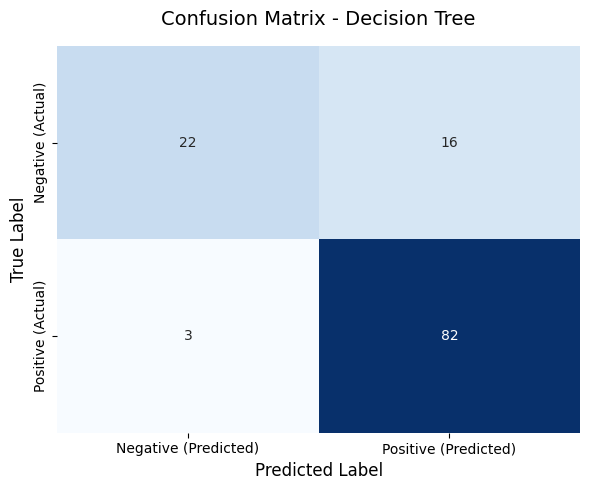

In [ ]:
# Decision Tree
param_grid_dt = {
    'max_depth': [3, 5, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

best_dt = evaluate_model(
    "Decision Tree",
    DecisionTreeClassifier(random_state=42),
    param_grid_dt,
    X_train, y_train,
    X_test, y_test
)

Best Params for XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}

Results for XGBoost
Test Accuracy: 0.8455284552845529
              precision    recall  f1-score   support

           0       0.95      0.53      0.68        38
           1       0.82      0.99      0.90        85

    accuracy                           0.85       123
   macro avg       0.89      0.76      0.79       123
weighted avg       0.86      0.85      0.83       123



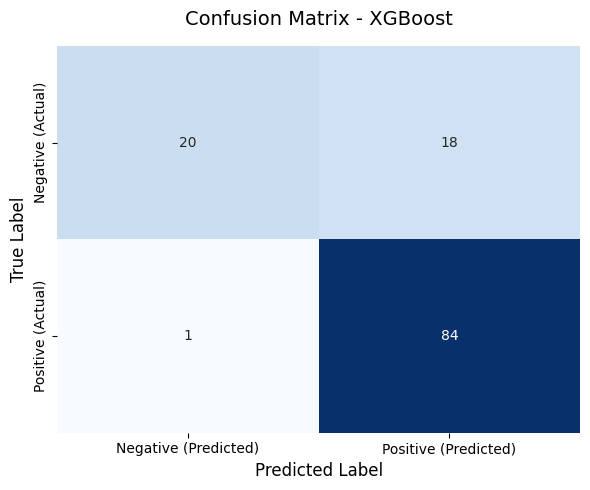

In [ ]:
# XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

best_xgb = evaluate_model(
    "XGBoost",
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid_xgb,
    X_train, y_train,
    X_test, y_test
)

Best Params for SVM: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}

Results for SVM
Test Accuracy: 0.8536585365853658
              precision    recall  f1-score   support

           0       0.95      0.55      0.70        38
           1       0.83      0.99      0.90        85

    accuracy                           0.85       123
   macro avg       0.89      0.77      0.80       123
weighted avg       0.87      0.85      0.84       123



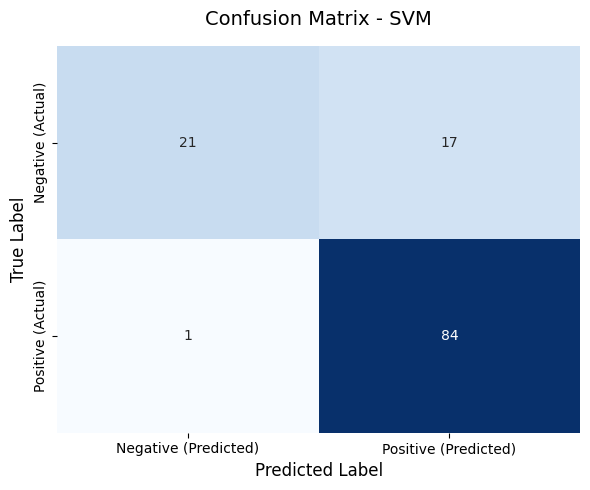

In [ ]:
# Support Vector Machine
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

best_svm = evaluate_model(
    "SVM",
    SVC(probability=True, random_state=42),
    param_grid_svm,
    X_train, y_train,
    X_test, y_test
)

Best Params for Random Forest: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 100}

Results for Random Forest
Test Accuracy: 0.8536585365853658
              precision    recall  f1-score   support

           0       0.86      0.63      0.73        38
           1       0.85      0.95      0.90        85

    accuracy                           0.85       123
   macro avg       0.85      0.79      0.81       123
weighted avg       0.85      0.85      0.85       123



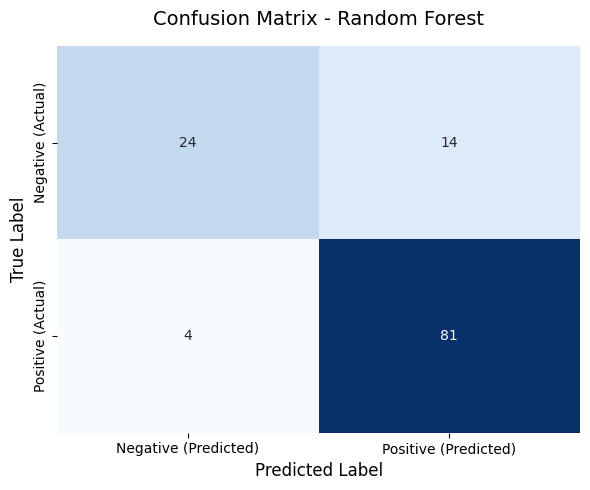

In [ ]:
# Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2']
}

best_rf = evaluate_model(
    "Random Forest",
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    X_train, y_train,
    X_test, y_test
)

Best Params for Logistic Regression: {'C': 0.01, 'solver': 'liblinear'}

Results for Logistic Regression
Test Accuracy: 0.8617886178861789
              precision    recall  f1-score   support

           0       0.96      0.58      0.72        38
           1       0.84      0.99      0.91        85

    accuracy                           0.86       123
   macro avg       0.90      0.78      0.81       123
weighted avg       0.88      0.86      0.85       123



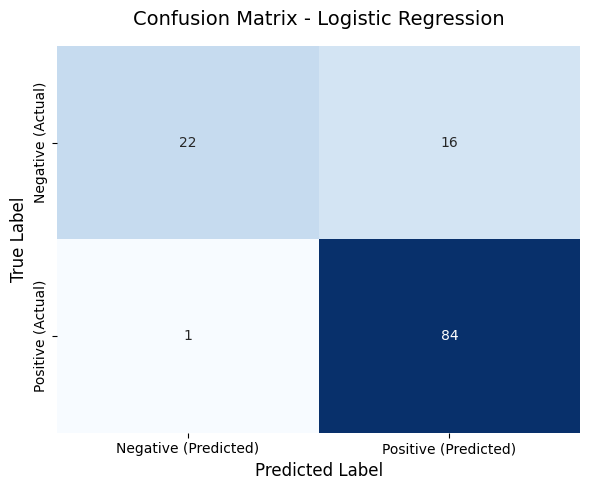

In [ ]:
# Logistic Regression
param_grid_lr = {
  'C': [0.01, 0.1, 1, 10],
  'solver': ['liblinear', 'lbfgs']
  }


best_lr = evaluate_model(
    "Logistic Regression",
    LogisticRegression(max_iter=5000, random_state=42),
    param_grid_lr,
    X_train, y_train,
    X_test, y_test
)

In [ ]:
best_model_name = max(test_accuracies, key=test_accuracies.get)
print("\nBest model is:", best_model_name, "with accuracy:", test_accuracies[best_model_name])

if best_model_name == "Logistic Regression":
    best_model = best_lr
elif best_model_name == "SVM":
    best_model = best_svm
elif best_model_name == "Decision Tree":
    best_model = best_dt
elif best_model_name == "Random Forest":
    best_model = best_rf
elif best_model_name == "XGBoost":
    best_model = best_xgb


Best model is: Logistic Regression with accuracy: 0.8617886178861789


##Final Model Evaluation & Results
Evaluating the best model obtained from GridSearchCV:
- Feature Importance (if available)
- Cross-Validation Performance
- Final Test Set Accuracy & Classification Report

In [ ]:
# Feature importance (only for tree-based models)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\nFeature Importance:")
    print(feature_importance)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title(f'Feature Importance ({best_model.__class__.__name__})')
    plt.tight_layout()
    plt.show()

# Cross-validation
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Final test evaluation
y_pred = best_model.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred)
print(f"\nFinal Test Accuracy: {final_accuracy:.4f}")

print("\nFinal Classification Report:")
print(classification_report(y_test, y_pred))

Cross-Validation Scores: [0.7979798  0.80612245 0.81632653 0.78571429 0.78571429]
Mean CV Accuracy: 0.7984 (+/- 0.0237)

Final Test Accuracy: 0.8618

Final Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.58      0.72        38
           1       0.84      0.99      0.91        85

    accuracy                           0.86       123
   macro avg       0.90      0.78      0.81       123
weighted avg       0.88      0.86      0.85       123

